### Franka Robot Grasping and Objects Sclerp Tutorial: Without Spinning Pads (Rotational Slippage)


In [1]:
import genesis as gs
import numpy as np
import torch
from pytransform3d import (
    transformations as pt,
    rotations as pr,
    batch_rotations as pb,
    trajectories as ptr,
    plot_utils as ppu
)

from pandaSim.geometry.genesis_adapter import GenesisAdapter
from pandaSim.planning.screw_motion_planner import ScrewMotionPlanner

In [2]:
gs.destroy()
gs.init(backend=gs.cpu)
gs.set_random_seed(seed=42)
#config = {'viewr_option' : {'width': 640, 'height': 480}, 'box_box_detection': True}
adapter = GenesisAdapter()
scene = adapter.scene

[Genesis] [18:39:55] [INFO] ╭───────────────────────────────────────────────╮
[Genesis] [18:39:55] [INFO] │┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈ Genesis ┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈┉┈│
[Genesis] [18:39:55] [INFO] ╰───────────────────────────────────────────────╯
[Genesis] [18:39:56] [INFO] Running on [13th Gen Intel(R) Core(TM) i7-13800H] with backend gs.cpu. Device memory: 31.59 GB.
[Genesis] [18:39:56] [INFO] 🚀 Genesis initialized. 🔖 version: 0.2.1, 🌱 seed: None, 📏 precision: '32', 🐛 debug: False, 🎨 theme: 'dark'.
[Genesis] [18:39:56] [INFO] Scene <148ae6b> created.


In [3]:
plane = scene.add_entity(
    gs.morphs.Plane(),
)
franka = scene.add_entity(
    gs.morphs.MJCF(file='xml/franka_emika_panda/panda.xml'),
)
                          
# table = scene.add_entity(
#     gs.morphs.MJCF(file='../model/common_arena/tables.xml'),
# )

table1 = scene.add_entity(
    gs.morphs.Box(
        size = (0.7, 1.7, 0.02),
        pos = (0.5, 0, 0.18),
        fixed = True,
    ),
    surface=gs.surfaces.Default(
        color = (0.5, 0.5, 0.5),
    ),
    material=gs.materials.Rigid(
        gravity_compensation=1.0 ,
        friction=5.0
    )
)
        
table2 = scene.add_entity(
    gs.morphs.Box(
        size = (0.7, 1.7, 0.02),
        pos = (-0.5, 0, 0.18),
        fixed = True,
    ),
    surface=gs.surfaces.Default(
        color = (0.5, 0.5, 0.5),
    ),
    material=gs.materials.Rigid(
        gravity_compensation=1.0,
        friction=5.0
    )
)

table3 = scene.add_entity(
    gs.morphs.Box(
        size = (0.3, 0.7, 0.02),
        pos = (0, -0.5, 0.18),
        fixed = True,
    ),
    surface=gs.surfaces.Default(
        color = (0.5, 0.5, 0.5),
    ),
    material=gs.materials.Rigid(
        gravity_compensation=1.0,
        friction=5.0
    )
)

table4 = scene.add_entity(
    gs.morphs.Box(
        size = (0.3, 0.7, 0.02),
        pos = (0, 0.5, 0.18),
        fixed = True,
    ),
    surface=gs.surfaces.Default(
        color = (0.5, 0.5, 0.5),
    ),
    material=gs.materials.Rigid(
        gravity_compensation=1.0,
        friction=5.0
    )
)

bottle = scene.add_entity(
    material=gs.materials.Rigid(rho=300),
    morph=gs.morphs.URDF(
        file="urdf/3763/mobility_vhacd.urdf",
        scale=0.09,
        pos=(0.65, 0.0, 0.036 + 0.19),
        quat=(-np.pi/2, 0, np.pi/2, 0),
    ),
    # visualize_contact=True,
)

# bottle = scene.add_entity(
#     morph = gs.morphs.URDF(
#         file="../assets/urdf/bottle/bottle.urdf",
#         scale=0.1,
#         pos=(0.65, 0.4, 0.036 + 0.19),
#         quat=(-np.pi/2, 0, np.pi/2, 0),
#     ),
# )
cube_size = (0.07, 0.1, 0.1)
cube_pos = (0.4, 0.4, 0.05+0.19)

cube = scene.add_entity(
    gs.morphs.Box(
        size = cube_size,
        pos  = cube_pos,
    ),
    surface=gs.surfaces.Default(
        color = (0.8, 0.1 , 0.1),   
    )
)
cube.surface.color = (0.8, 0.1 , 0.1)

cylinder_pos = (0.7, -0.2, 0.03+0.19)
cylinder_quat = (0, -np.sqrt(2)/2, 0, np.sqrt(2)/2)
cylinder_radius = 0.03
cylinder_height = 0.15

cylinder = scene.add_entity(
    gs.morphs.Cylinder(
        radius = cylinder_radius,
        height = cylinder_height,
        pos    = cylinder_pos,
        quat   = cylinder_quat,
    ),
    surface=gs.surfaces.Default(
        color = (0.1, 0.8 , 0.1),   
    )
)
cylinder.surface.color = (0.2, 0.8, 0.2)

cam = scene.add_camera(
    res    = (640, 480),
    pos    = (3.5, 0.0, 2.5),
    lookat = (0, 0, 0.5),
    fov    = 30,
    GUI    = False,
)

[Genesis] [18:39:59] [INFO] Adding <gs.RigidEntity>. idx: 0, uid: <f8fe595>, morph: <gs.morphs.Plane>, material: <gs.materials.Rigid>.
[Genesis] [18:39:59] [INFO] Adding <gs.RigidEntity>. idx: 1, uid: <4a2b334>, morph: <gs.morphs.MJCF(file='d:\envs\Panda\lib\site-packages\genesis\assets\xml/franka_emika_panda/panda.xml')>, material: <gs.materials.Rigid>.
[Genesis] [18:40:00] [WARNING] (MJCF) Tendon not supported
[Genesis] [18:40:00] [WARNING] (MJCF) Approximating tendon by joint actuator for `finger_joint1`
[Genesis] [18:40:00] [WARNING] (MJCF) Actuator control gain and bias parameters cannot be reduced to a unique PD control position gain. Using max between gain and bias.
[Genesis] [18:40:00] [WARNING] (MJCF) Approximating tendon by joint actuator for `finger_joint2`
[Genesis] [18:40:00] [WARNING] (MJCF) Actuator control gain and bias parameters cannot be reduced to a unique PD control position gain. Using max between gain and bias.
[Genesis] [18:40:00] [INFO] Adding <gs.RigidEntity>.

In [4]:
# n_envs = 1
# scene.build(n_envs=n_envs, env_spacing=(2, 2), center_envs_at_origin=True ,compile_kernels=False)
scene.build()

[Genesis] [18:40:08] [INFO] Building scene <148ae6b>...
[Genesis] [18:40:09] [WARNING] Reference robot position exceeds joint limits.
[Genesis] [18:40:12] [INFO] Compiling simulation kernels...
[Genesis] [18:40:22] [INFO] Building visualizer...
[Genesis] [18:40:26] [INFO] Viewer created. Resolution: 1280×960, max_FPS: 60.


In [6]:
motors_dof = np.arange(7)
fingers_dof = np.arange(7, 9)
# set control gains
# Note: the following values are tuned for achieving best behavior with Franka
# Typically, each new robot would have a different set of parameters.
# Sometimes high-quality URDF or XML file would also provide this and will be parsed.
franka.set_dofs_kp(
    np.array([4500, 4500, 3500, 3500, 2000, 2000, 2000, 100, 100]),
)
franka.set_dofs_kv(
    np.array([450, 450, 350, 350, 200, 200, 200, 10, 10]),
)
franka.set_dofs_force_range(
    np.array([-87, -87, -87, -87, -12, -12, -12, -100, -100]),
    np.array([ 87,  87,  87,  87,  12,  12,  12,  100,  100]),
)

In [5]:
# get bottle properties
bottle_pos = bottle.get_pos()
print(f"bottle_pos: {bottle_pos}")
bottle_rot = bottle.get_quat()
print(f"bottle_rot: {bottle_rot}")
bottle_mass = bottle.get_mass()
print(f"bottle_mass: {bottle_mass}")

planner = ScrewMotionPlanner()
bottle_bbox = adapter.get_bbox(bottle)
planner.find_ground_edges(bottle_bbox)
bottle_qs, bottle_s_axes = planner.screw_from_bbox(bottle_bbox)
print(f"bottle screw params qs: {bottle_qs}")
print(f"bottle screw params s_axes: {bottle_s_axes}")
# bottle_vertices = bottle.get_verts()
# print(f"bottle_vertices: {bottle_vertices}")
bottle_bbox = bottle.get_AABB()
bottle.size = bottle_bbox[1] - bottle_bbox[0]

# get cubes prperties
cube_pos = cube.get_pos()
print(f"cube_pos: {cube_pos}")
cube_rot = cube.get_quat()
print(f"cube_rot: {cube_rot}")
cube_mass = cube.get_mass()
print(f"cube_mass: {cube_mass}")
cube_vertices = cube.get_verts()
print(f"cube_vertices: {cube_vertices}")

cube.size = cube_size

# get cylinder properties
cylinder_pos = cylinder.get_pos()
print(f"cylinder_pos: {cylinder_pos}")
cylinder_rot = cylinder.get_quat()
print(f"cylinder_rot: {cylinder_rot}")
cylinder_mass = cylinder.get_mass()
print(f"cylinder_mass: {cylinder_mass}")
# cylinder_vertices = cylinder.get_verts()
# print(f"cylinder_vertices: {cylinder_vertices}")
cylinder.size = (cylinder_height, cylinder_radius)

bottle_pos: tensor([0.6500, 0.0000, 0.2260])
bottle_rot: tensor([-0.7071,  0.0000,  0.7071,  0.0000])
bottle_mass: 0.09222162768927847
bottle screw params qs: [[5.6069762e-01 4.7992636e-04 1.9216135e-01]
 [7.2746480e-01 4.7992636e-04 1.9216135e-01]]
bottle screw params s_axes: [[0. 1. 0.]
 [0. 1. 0.]]
cube_pos: tensor([0.4000, 0.4000, 0.2400])
cube_rot: tensor([1., 0., 0., 0.])
cube_mass: 0.14000000000000004
cube_vertices: tensor([[0.3650, 0.3500, 0.1900],
        [0.3650, 0.3500, 0.2900],
        [0.3650, 0.4500, 0.1900],
        [0.3650, 0.4500, 0.2900],
        [0.4350, 0.3500, 0.1900],
        [0.4350, 0.3500, 0.2900],
        [0.4350, 0.4500, 0.1900],
        [0.4350, 0.4500, 0.2900]])
cylinder_pos: tensor([ 0.7000, -0.2000,  0.2200])
cylinder_rot: tensor([ 0.0000, -0.7071,  0.0000,  0.7071])
cylinder_mass: 0.0842790191109674


In [7]:
def get_obj_screw(object):
    """
    Get the screw parameters of the object
    """
    if object == bottle:
        planner = ScrewMotionPlanner()
        bottle_bbox = adapter.get_bbox(bottle)
        planner.find_ground_edges(bottle_bbox)
        bottle_qs, bottle_s_axes = planner.screw_from_bbox(bottle_bbox)
        s1, s2 = bottle_s_axes
        q1, q2 = bottle_qs
        h1 = 0
        h2 = 0
    else:
        # get the vertices of the object
        vertices = object.get_verts()
        vertices = vertices.numpy()

        # get the max and min x, y, z coordinates
        max_x = np.max(vertices[:, 0])
        min_x = np.min(vertices[:, 0])
        min_y = np.min(vertices[:, 1])
        min_z = np.min(vertices[:, 2])
        max_y = np.max(vertices[:, 1])
        
        v1 = np.array([max_x, min_y, min_z])  # max x, min y, min z
        v2 = np.array([max_x, max_y, min_z])  # max x, max y, min z
        v3 = np.array([min_x, max_y, min_z])  # min x, max y, min z
        v4 = np.array([min_x, min_y, min_z])  # min x, min y, min z
        
        if np.linalg.norm(v1-v2) <= np.linalg.norm(v2-v3):
            s1 = (v1-v2) / np.linalg.norm(v1-v2) # unit vector in the direction of the screw axis
            q1 = v2 # point on the screw axis
            h1 = 0 # pitch of the screw axis
            s2 = (v4-v3) / np.linalg.norm(v4-v3) # unit vector in the direction of the screw axis
            q2 = v4 # point on the screw axis
            h2 = 0 # pitch of the screw axis
        else:
            s1 = (v2-v3) / np.linalg.norm(v2-v3) # unit vector in the direction of the screw axis
            q1 = v2 # point on the screw axis
            h1 = 0 # pitch of the screw axis
            s2 = (v1-v4) / np.linalg.norm(v1-v4) # unit vector in the direction of the screw axis
            q2 = v1 # point on the screw axis
            h2 = 0 # pitch of the screw axis
    
    #pt.check_screw_parameters(q, s, h) # check if the screw parameters are valid
    return s1, q1, h1, s2, q2, h2


def obj_dq(object, method):
    """
    Get the screw parameters of the object and apply sclerp to the object in dual quaternion
    """
    if method == 'min_distance':
        _,_,_,s,q,h = get_obj_screw(object)
        theta = np.pi/2
    elif method == 'max_distance':
        s,q,h,_,_,_ = get_obj_screw(object)
        theta = -np.pi/2

    
    pq = object.get_qpos().cpu().numpy()
    pq = pq[0:7] # position and quaternion of the object
    obj_initial_dq = pt.dual_quaternion_from_pq(pq) # dual quaternion from position and quaternion
    
    Screw_dq = pt.dual_quaternion_from_screw_parameters(q=q, s_axis=s, h=h, theta=theta) # dual quaternion from screw parameters that make the object upright
    # intermediate_T = pt.transform_log_from_screw_matrix
    # Screw_T = pt.transform_from_dual_quaternion(Screw_dq) # transform from dual quaternion to transformation matrix
    # print("screw_dq: \n", Screw_dq)
    # print("screw_T: \n", Screw_T)
    obj_goal_dq = pt.concatenate_dual_quaternions(Screw_dq, obj_initial_dq)
    #obj_goal_T = pt.transform_from_dual_quaternion(obj_goal_dq) # transform from dual quaternion to transformation matrix
    # print("obj_goal_dq: \n", obj_goal_dq)
    # print("obj_goal_T: \n", obj_goal_T)
    return obj_initial_dq, obj_goal_dq


def obj_sclerp(object, obj_initial_dq, obj_goal_dq, method, steps):
    """
    Apply sclerp to the object in dual quaternion
    """
    s = np.linspace(0, 1, steps)
    if method == 'linear':
        tau = s
    if method == 'cubic':
        tau = 3*s**2 - 2*s**3
    if method == 'quintic':
        tau = 10*s**3 - 15*s**4 + 6*s**5
        
    # get the dual quaternion of the object
    dq_traj = [pt.dual_quaternion_sclerp(obj_initial_dq, obj_goal_dq, t) for t in tau]
         # spherical linear interpolation between two dual quaternions
    # get the position and quaternion from the dual quaternion
    dq_traj = np.asarray(dq_traj)
    obj_qpos = ptr.pqs_from_dual_quaternions(dq_traj)
    
    return dq_traj, obj_qpos

def obj_grasp_offset(object, object_initial_dq, method):
    
    m = 1
    if method == 'min_distance':
        m = -1
    
    if object == cube:
        length = cube.size[0]
        width = cube.size[1]
        height = cube.size[2]    
            
        T_initial = pt.transform_from_dual_quaternion(object_initial_dq) # transform from dual quaternion to transformation matrix
        T_offset = np.array([[1, 0, 0, 0],
                             [0, 1, 0, m*(-width/2 + 0.02)],
                             [0, 0, 1, height/2 - 0.02],
                             [0, 0, 0, 1]])
        T_ee = np.array([[0, 1, 0, 0],
                         [1, 0, 0, 0],
                         [0, 0, -1, 0.11],
                         [0, 0, 0, 1]])
 
        # rot = sm.SE3.RPY(0, np.pi/3, 0).A # rotation matrix from the object to the end effector
        T_grasp = T_initial @ T_offset @ T_ee  # transformation matrix from the object to the end effector
        
    elif object == cylinder:
        length = cylinder.size[0]
            
        T_initial = pt.transform_from_dual_quaternion(object_initial_dq) # transform from dual quaternion to transformation matrix
        T_offset = np.array([[1, 0, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, -m*(-length/2 + 0.02)],
                             [0, 0, 0, 1]])
        # T_ee = np.array([[1, 0, 0, 0],
        #                  [0, -1, 0, 0],
        #                  [0, 0, -1, 0.11],
        #                  [0, 0, 0, 1]])
        T_ee = np.array([[0, 0, 1, -0.11],
                         [0, 1, 0, 0],
                         [-1, 0, 0, 0],
                         [0, 0, 0, 1]])
        # rot = sm.SE3.RPY(0, np.pi/3, 0).A # rotation matrix from the object to the end effector
        T_grasp = T_initial @ T_offset @ T_ee  # transformation matrix from the object to the end effector
        
    elif object == bottle:
        length = bottle.size[0]
        width = bottle.size[1]
        height = bottle.size[2]
            
        T_initial = pt.transform_from_dual_quaternion(object_initial_dq) 
        T_offset = np.array([[1, 0, 0, 0],
                             [0, 1, 0, 0],
                             [0, 0, 1, m*(-0.03)],
                             [0, 0, 0, 1]])
        T_ee = np.array([[0, 0, -1, 0.11],
                         [0, -1, 0, 0],
                         [-1, 0, 0, 0],
                         [0, 0, 0, 1]])
        T_grasp = T_initial @ T_offset @ T_ee       
    return T_grasp
    
def obj_grasp(object, method):
    """
    grasping the object
    """
    
    # get the dual quaternion of the object
    obj_initial_dq, obj_goal_dq = obj_dq(object, method)

    T_grasp = obj_grasp_offset(object, obj_initial_dq, method) 
    print("T_grasp: \n", T_grasp)
    pq_grasp = pt.pq_from_transform(T_grasp) # position and quaternion from transformation matrix
    return pq_grasp


def franka_sclerp(object, robot, method, method2, steps):
    franka_initial_p, franka_initial_q = robot.forward_kinematics(robot.get_qpos(), links_idx_local=[8]) # get the position and quaternion of the end effector
    franka_initial_pq = np.concatenate((franka_initial_p, franka_initial_q), axis=1).reshape(7) # position and quaternion of the end effector
    franka_initial_dq = pt.dual_quaternion_from_pq(franka_initial_pq) # dual quaternion from position and quaternion
    if method2 == 'min_distance':
        _,_,_,s,q,h = get_obj_screw(object)
        theta = np.pi/2
    elif method2 == 'max_distance':
        s,q,h,_,_,_ = get_obj_screw(object)
        theta = -np.pi/2
        
    Screw_dq = pt.dual_quaternion_from_screw_parameters(q=q, s_axis=s, h=h, theta=theta) # dual quaternion from screw parameters that make the object upright
    franka_goal_dq = pt.concatenate_dual_quaternions(Screw_dq, franka_initial_dq)
    
    s = np.linspace(0, 1, steps)
    if method == 'linear':
        tau = s
    if method == 'cubic':
        tau = 3*s**2 - 2*s**3
    if method == 'quintic':
        tau = 10*s**3 - 15*s**4 + 6*s**5
        
    # get the dual quaternion of the object
    franka_dq_traj = [pt.dual_quaternion_sclerp(franka_initial_dq, franka_goal_dq, t) for t in tau]# spherical linear interpolation between two dual quaternions
    franka_dq_traj = np.asarray(franka_dq_traj)
    # get the position and quaternion from the dual quaternion
    franka_pqs = ptr.pqs_from_dual_quaternions(franka_dq_traj)
    return franka_pqs

def Success_Rate(obj_init_T, obj_goal_T, obj_current_T, method):
    """
    Compare the goal and current transformation and give a success rate based on that.
    """
    
    threshold = 0.2
    # Compute pose difference in SE(3)
    eTep = np.linalg.inv(obj_current_T) @ obj_goal_T
    
    # Initialize error vector
    e_log = np.zeros(6)
    e_rpy = np.zeros(6)
    e = np.zeros(6)
    
    if method == "axis_angle":
        # Get translational error
        e_log[:3] = eTep[:3, 3]
        
        # Get rotational error as axis-angle
        rot_matrix = eTep[:3, :3]
        axis_ang = pr.axis_angle_from_matrix(rot_matrix)
        axis = axis_ang[:3]
        angle = axis_ang[3]
        e_log[3:] = axis * angle if angle != 0 else np.zeros(3)
        # Check if arrived at target
        arrived = np.linalg.norm(np.abs(e_log)) < threshold
        e = e_log
    elif method == "rpy":
        # RPY method
        e_rpy[:3] = eTep[:3, 3]
        e_rpy[3:] = pr.euler_from_matrix(eTep[:3, :3], 0, 1, 2, extrinsic=False)
        # Check if arrived at target
        arrived = np.linalg.norm(np.abs(e_rpy)) < threshold
        e = e_rpy
    #elif method =='log':
        
    angular_rate = 1 - np.linalg.norm(np.abs(e[3:])) / (np.pi/2)   
    trans_rate = 1 - np.linalg.norm(np.abs(e[:3])) / np.linalg.norm(np.abs(obj_goal_T[:3,3]- obj_init_T[:3,3]))
    Success = ((angular_rate+trans_rate)/2)*100
    return e, Success, arrived

In [ ]:
# p, q = franka.forward_kinematics(franka.get_qpos(), links_idx_local=[8])
# franka_pq = np.concatenate((p, q), axis=1).reshape(7) # position and quaternion of the end effector
# franka_pq
# franka_T = pt.transform_from_pq(franka_pq) # transformation matrix from position and quaternion
# print("franka_T: \n", franka_T)

In [ ]:
# # check if the end effector is in the right pregrasp pose
# print("pregrasp pose: ", pq_grasp_cube)
# print("end effector pose: ", end_effector.get_pos())

### Uprighting the bottle

In [31]:
# franka is in ready position
scene.reset()
bottle.set_pos([0.1, -0.45, 0.035+0.19])
bot_initial_dq, bot_goal_dq = obj_dq(bottle, 'min_distance')
bot_init_T = pt.transform_from_dual_quaternion(bot_initial_dq)
bot_goal_T = pt.transform_from_dual_quaternion(bot_goal_dq)
qr = np.array([0.0000, -0.3002, 0.0000, -2.1991, 0.0000, 2.0071, 0.7854, 0.04, 0.04])
franka.ready_qpos = qr
franka.set_qpos(franka.ready_qpos)
scene.step()

[Genesis] [18:53:43] [INFO] Resetting Scene <148ae6b>.


In [32]:
# move to pre-grasp pose for bottle
end_effector = franka.get_link('hand')
left_finger = franka.get_link('left_finger')
right_finger = franka.get_link('right_finger')

pq_grasp_bottle = obj_grasp(bottle, 'min_distance')
print(pq_grasp_bottle)
print(pt.transform_from_pq(pq_grasp_bottle))
q_pregrasp = franka.inverse_kinematics(
    link = end_effector,
    pos = pq_grasp_bottle[:3] , # position of the end effector
    quat = pq_grasp_bottle[3:7], # quaternion from the transformation matrix
    #rot_mask = [False, False, False]
)


franka.set_qpos(q_pregrasp)
franka.control_dofs_position(q_pregrasp)
#bottle.set_dofs_position(np.array([0, 0]), [6,7])


for __ in range(100):
    bottle.control_dofs_position(np.array([0, 0]), [6,7])
    scene.step()

T_grasp: 
 [[ 9.99999999e-01 -4.53262537e-05 -8.17648978e-06  7.01792902e-02]
 [-4.53262542e-05 -9.99999999e-01 -6.04985411e-08 -4.49998622e-01]
 [-8.17648703e-06  6.08691507e-08 -1.00000000e+00  3.34448420e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 7.01792902e-02 -4.49998622e-01  3.34448420e-01  3.03419229e-08
  1.00000000e+00 -2.26631270e-05 -4.08824420e-06]
[[ 9.99999999e-01 -4.53262537e-05 -8.17648978e-06  7.01792902e-02]
 [-4.53262542e-05 -9.99999999e-01 -6.04985411e-08 -4.49998622e-01]
 [-8.17648703e-06  6.08691507e-08 -1.00000000e+00  3.34448420e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [33]:
# closing fingers to grasp the bottle
franka.control_dofs_force(np.array([-10, -10]), fingers_dof)
franka.control_dofs_position(q_pregrasp[:-2], motors_dof)
for _ in range(50):
    scene.step()

In [27]:
# initial_franka = franka.forward_kinematics(franka.get_qpos(), links_idx_local=[8])
# initial_pq = adapter.to(initial_franka, output_type='pq').reshape(7)
# franka_pqs = planner.generate_screw_trajectory(initial_pose=initial_pq, 
#                                                q=q, s_axis=s, theta=np.pi/2, h=h,  steps=100, output_type='p')

In [34]:
# franka sclerp to upright the bottle
franka_pqs = franka_sclerp(bottle, franka, method='quintic', method2='min_distance', steps=500)
init_q = franka.get_qpos() 
qs = []
for pq in franka_pqs:
    q = franka.inverse_kinematics(
        link=end_effector,
        pos=pq[:3],
        quat=pq[3:7],
        init_qpos=init_q,
        # pos_tol=5e-5,  # 0.5 mm
        # rot_tol=5e-5,  # 0.28 degree
        #rot_mask = [False, True, False],
    )
    init_q = q
    qs.append(q)

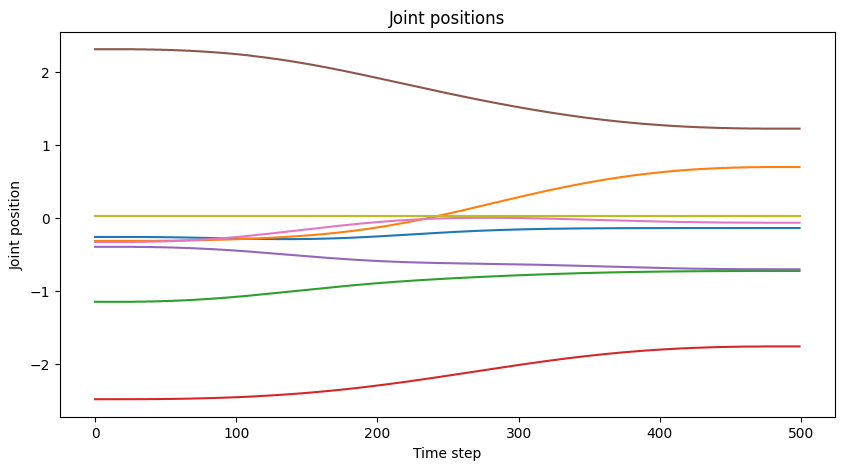

In [35]:
# plot joint positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(qs)
plt.title('Joint positions')
plt.xlabel('Time step')
plt.ylabel('Joint position')
plt.show()

In [36]:
qs = np.array(qs)
for q in qs:
    franka.control_dofs_force(np.array([-10, -10]), fingers_dof)
    #franka.control_dofs_position(np.array([0.02, 0.02]), fingers_dof)
    franka.control_dofs_position(q[:-2], motors_dof)
    #franka.set_qpos(q[:-2], motors_dof)

    scene.step() 

In [37]:
franka.control_dofs_force(np.array([0, 0]), fingers_dof)
for _ in range(50):
    
    scene.step()

In [38]:
bot_current_T = pt.transform_from_pq(bottle.get_qpos()[0:7])
Success_Rate(bot_init_T, bot_goal_T, bot_current_T, method='axis_angle')

(array([ 0.00225668, -0.00380801,  0.00153653, -0.0016221 ,  0.00055255,
         0.00601054]),
 np.float64(97.8413536729593),
 np.True_)

### Uprighting the cylinder

In [39]:
# franka is in ready position
scene.reset()
cylinder.set_pos([0, -0.35, 0.03 +0.19])
cyl_initial_dq, cyl_goal_dq = obj_dq(cylinder, 'min_distance')
cyl_init_T = pt.transform_from_dual_quaternion(cyl_initial_dq)
cyl_goal_T = pt.transform_from_dual_quaternion(cyl_goal_dq)
qr = np.array([0.0000, -0.3002, 0.0000, -2.1991, 0.0000, 2.0071, 0.7854, 0.04, 0.04])
franka.ready_qpos = qr
franka.set_qpos(franka.ready_qpos)
scene.step()

[Genesis] [18:54:37] [INFO] Resetting Scene <148ae6b>.


In [40]:
# move to pre-grasp pose for cylinder
end_effector = franka.get_link('hand')
left_finger = franka.get_link('left_finger')
right_finger = franka.get_link('right_finger')

pq_grasp_cylinder = obj_grasp(cylinder, 'min_distance')
print(pq_grasp_cylinder)
print(pt.transform_from_pq(pq_grasp_cylinder))
q_pregrasp = franka.inverse_kinematics(
    link = end_effector,
    pos = pq_grasp_cylinder[:3] , # position of the end effector
    quat = pq_grasp_cylinder[3:7], # quaternion from the transformation matrix
    #rot_mask = [False, False, False]
)


franka.set_qpos(q_pregrasp)
franka.control_dofs_position(q_pregrasp)

for __ in range(100):
    scene.step()

T_grasp: 
 [[ 9.99999997e-01 -1.42724468e-09  8.07533562e-05  5.49888683e-02]
 [-1.50107553e-09 -1.00000000e+00  9.14275941e-07 -3.50000095e-01]
 [ 8.07533562e-05 -9.14276059e-07 -9.99999997e-01  3.29593913e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 5.49888683e-02 -3.50000095e-01  3.29593913e-01 -4.57138000e-07
  9.99999999e-01 -7.32080053e-10  4.03766781e-05]
[[ 9.99999997e-01 -1.42724468e-09  8.07533562e-05  5.49888683e-02]
 [-1.50107553e-09 -1.00000000e+00  9.14275941e-07 -3.50000095e-01]
 [ 8.07533562e-05 -9.14276059e-07 -9.99999997e-01  3.29593913e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [41]:
# closing fingers to grasp the cylinder
franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
franka.control_dofs_position(q_pregrasp[:-2], motors_dof)
for _ in range(50):
    scene.step()

In [42]:
# franka sclerp to upright the cylinder
franka_pqs = franka_sclerp(cylinder, franka, method='quintic', method2='min_distance', steps=300)
init_q = franka.get_qpos()
qs = []
for pq in franka_pqs:
    q = franka.inverse_kinematics(
        link=end_effector,
        pos=pq[:3],
        quat=pq[3:7],
        init_qpos=init_q,
        # pos_tol=5e-5,  # 0.5 mm
        # rot_tol=5e-5,  # 0.28 degree
        #rot_mask = [False, True, False],
    )
    init_q = q
    qs.append(q)

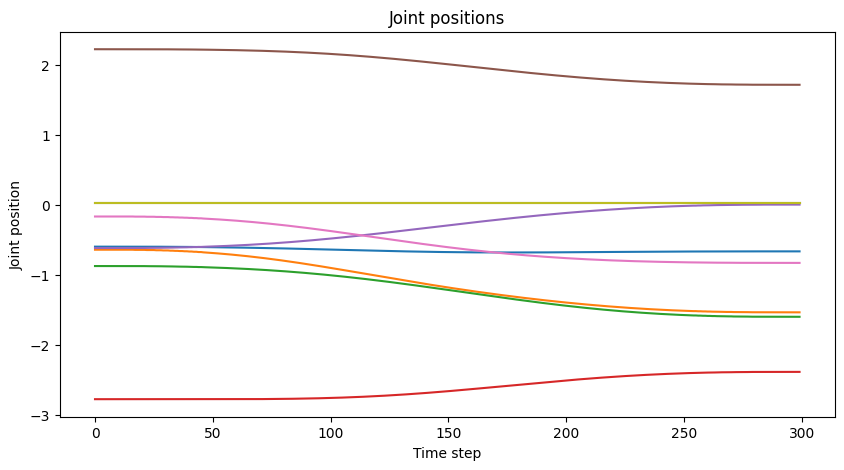

In [43]:
# plot joint positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(qs)
plt.title('Joint positions')
plt.xlabel('Time step')
plt.ylabel('Joint position')
plt.show()

In [44]:
qs = np.array(qs)
for q in qs:
    franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
    #franka.control_dofs_position(np.array([0.02, 0.02]), fingers_dof)
    franka.control_dofs_position(q[:-2], motors_dof)
    #franka.set_qpos(q[:-2], motors_dof)

    scene.step()   
    

In [45]:
franka.control_dofs_force(np.array([0, 0]), fingers_dof)
for _ in range(150):
    
    scene.step()

In [46]:
cyl_current_T = pt.transform_from_pq(cylinder.get_qpos())
Success_Rate(cyl_init_T, cyl_goal_T, cyl_current_T, method='axis_angle')

(array([ 4.13948170e-03,  2.34839285e-03, -3.69426252e-04, -6.78152805e-06,
         9.70652507e-06, -9.13407488e-02]),
 np.float64(95.00321011839662),
 np.True_)

### Uprighting the cube

In [47]:
# franka is in ready position
scene.reset()
cube.set_pos([0.45,0.2,0.05+0.19])
cube_initial_dq, cube_goal_dq = obj_dq(cube, 'min_distance')
cube_init_T = pt.transform_from_dual_quaternion(cube_initial_dq)
cube_goal_T = pt.transform_from_dual_quaternion(cube_goal_dq)
qr = np.array([0.0000, -0.3002, 0.0000, -2.1991, 0.0000, 2.0071, 0.7854, 0.04, 0.04])
franka.ready_qpos = qr
franka.set_qpos(franka.ready_qpos)
scene.step()

[Genesis] [18:55:25] [INFO] Resetting Scene <148ae6b>.


In [48]:
# move to pre-grasp pose for cube
end_effector = franka.get_link('hand')
left_finger = franka.get_link('left_finger')
right_finger = franka.get_link('right_finger')

pq_grasp_cube = obj_grasp(cube, 'min_distance')
print(pq_grasp_cube)
print(pt.transform_from_pq(pq_grasp_cube))
q_pregrasp = franka.inverse_kinematics(
    link = end_effector,
    pos = pq_grasp_cube[:3] , # position of the end effector
    quat = pq_grasp_cube[3:7], # quaternion from the transformation matrix
    #rot_mask = [False, False, False]
)


franka.set_qpos(q_pregrasp)
franka.control_dofs_position(q_pregrasp)

for __ in range(100):
    scene.step()

T_grasp: 
 [[-1.62461548e-07  1.00000000e+00 -2.99353559e-05  4.50005396e-01]
 [ 9.99999999e-01  1.61091362e-07 -4.57714801e-05  2.30008408e-01]
 [-4.57714753e-05 -2.99353633e-05 -9.99999999e-01  3.79682910e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[ 4.50005396e-01  2.30008408e-01  3.79682910e-01  5.59891325e-06
  7.07106724e-01  7.07106838e-01 -2.67664090e-05]
[[-1.62461549e-07  1.00000000e+00 -2.99353559e-05  4.50005396e-01]
 [ 9.99999999e-01  1.61091363e-07 -4.57714801e-05  2.30008408e-01]
 [-4.57714753e-05 -2.99353633e-05 -9.99999999e-01  3.79682910e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [49]:
# closing fingers to grasp the cube
franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
franka.control_dofs_position(q_pregrasp[:-2], motors_dof)
for _ in range(50):
    scene.step()

In [50]:
# franka sclerp to upright the cube
franka_pqs = franka_sclerp(cube, franka, method='quintic', method2='min_distance', steps=300)
init_q = franka.get_qpos()
qs = []
for pq in franka_pqs:
    q = franka.inverse_kinematics(
        link=end_effector,
        pos=pq[:3],
        quat=pq[3:7],
        init_qpos=init_q,
        # pos_tol=5e-5,  # 0.5 mm
        # rot_tol=5e-5,  # 0.28 degree
        #rot_mask = [False, True, False],
    )
    init_q = q
    qs.append(q)

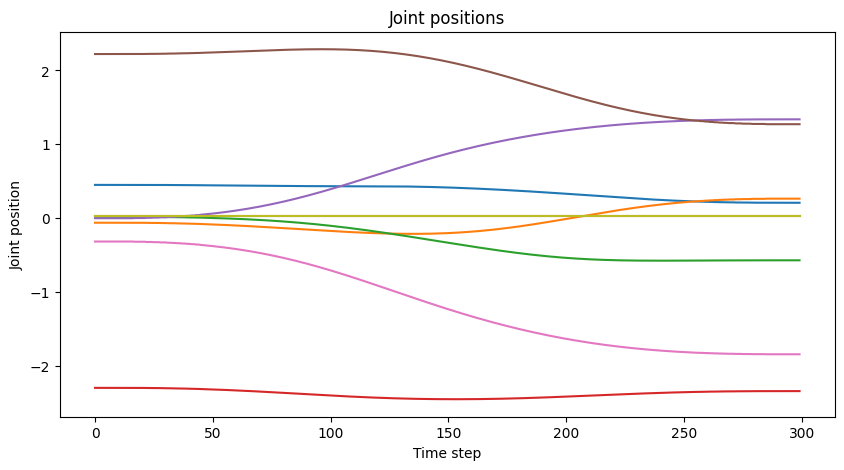

In [51]:
# plot joint positions
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(qs)
plt.title('Joint positions')
plt.xlabel('Time step')
plt.ylabel('Joint position')
plt.show()

In [52]:
qs = np.array(qs)
for q in qs:
    franka.control_dofs_force(np.array([-25, -25]), fingers_dof)
    #franka.control_dofs_position(np.array([0.02, 0.02]), fingers_dof)
    franka.control_dofs_position(q[:-2], motors_dof)
    #franka.set_qpos(q[:-2], motors_dof)

    scene.step()   

In [53]:
franka.control_dofs_force(np.array([0, 0]), fingers_dof)
for _ in range(150):
    
    scene.step()

In [54]:
cube_current_T = pt.transform_from_pq(cube.get_qpos())
Success_Rate(cube_init_T, cube_goal_T, cube_current_T, method='axis_angle')

(array([ 5.37448740e-03,  4.28873286e-04, -1.08046003e-03,  9.49995169e-05,
        -1.15361133e-02, -3.91087359e-04]),
 np.float64(96.88318693524208),
 np.True_)

### Objects Sclerp

##### Cube min_distance

In [55]:
# calling functions for cube_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(cube)
cube_initial_dq, Cube_goal_dq = obj_dq(cube, 'min_distance')
dq_traj, obj_qpos = obj_sclerp(cube, cube_initial_dq, Cube_goal_dq, 'linear', 100)
# cube sclerp motion
scene.reset()
for i in range (obj_qpos.shape[0]):
    franka.set_qpos(qr)
    cube.set_qpos(obj_qpos[i])
    scene.step()

[Genesis] [18:56:12] [INFO] Resetting Scene <148ae6b>.
[Genesis] [18:56:12] [INFO] Resetting Scene <148ae6b>.


##### Cube max_distance

In [56]:
# calling functions for cube_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(cube)
cube_initial_dq, Cube_goal_dq = obj_dq(cube, 'max_distance')
dq_traj, obj_qpos = obj_sclerp(cube, cube_initial_dq, Cube_goal_dq, 'linear', 100)
# cube sclerp motion
scene.reset()
for i in range (obj_qpos.shape[0]):
    franka.set_qpos(qr)
    cube.set_qpos(obj_qpos[i])
    scene.step()

[Genesis] [18:56:16] [INFO] Resetting Scene <148ae6b>.
[Genesis] [18:56:16] [INFO] Resetting Scene <148ae6b>.


##### Cylinder min_distance

In [57]:
# calling functions for cylinder_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(cylinder)
cyl_initial_dq, cyl_goal_dq = obj_dq(cylinder, 'min_distance')
dq_traj, obj_qpos = obj_sclerp(cylinder, cyl_initial_dq, cyl_goal_dq, 'linear', 100)
# cylinder sclerp motion
scene.reset()
for i in range (obj_qpos.shape[0]):
    franka.set_qpos(qr)
    cylinder.set_qpos(obj_qpos[i])
    scene.step()

[Genesis] [18:56:19] [INFO] Resetting Scene <148ae6b>.
[Genesis] [18:56:19] [INFO] Resetting Scene <148ae6b>.


##### Cylinder max_distance

In [58]:
# calling functions for cylinder_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(cylinder)
cyl_initial_dq, cyl_goal_dq = obj_dq(cylinder, 'max_distance')
dq_traj, obj_qpos = obj_sclerp(cylinder, cyl_initial_dq, cyl_goal_dq, 'linear', 100)
# cylinder sclerp motion
scene.reset()
for i in range (obj_qpos.shape[0]):
    franka.set_qpos(qr)
    cylinder.set_qpos(obj_qpos[i])
    scene.step()

[Genesis] [18:56:23] [INFO] Resetting Scene <148ae6b>.
[Genesis] [18:56:23] [INFO] Resetting Scene <148ae6b>.


##### Bottle min_distance

In [59]:
# calling functions for bottle_sclerp
scene.reset()
s1, q1, h1 , s2, q2, h2 = get_obj_screw(bottle)
bottle_initial_dq, bottle_goal_dq = obj_dq(bottle, 'min_distance')
bottle_traj, bottle_qpos = obj_sclerp(bottle, bottle_initial_dq, bottle_goal_dq, 'linear', 100)
# bottle sclerp motion
scene.reset()
for i in range (bottle_qpos.shape[0]):
    franka.set_qpos(qr)
    bottle.set_qpos(np.append(bottle_qpos[i], [0,0]))
    scene.step()

[Genesis] [18:56:28] [INFO] Resetting Scene <148ae6b>.
[Genesis] [18:56:28] [INFO] Resetting Scene <148ae6b>.
